In [16]:
import Parity_Data_Generator
import numpy as np
from pyESN import ESN
import time

N = 4000   # number of datapoints
n = 3       # n-parity
timescale = 50
rng = np.random.RandomState(42)
slowESN_reservoirSize=300

nParityESN = ESN(n_inputs=1,
                          n_outputs=301,
                          n_reservoir=slowESN_reservoirSize,  
                          spectral_radius=0.6, 
                          leak_rate= 0.3,   # adjust leak_rate
                          sparsity=0.95,     # 0.95
                          noise=0.01,      # 0.001
                          input_shift=-0.5,    # 0
                          input_scaling=3,  
                          teacher_forcing=False,
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          random_state=rng,
                          silent=False)
nParityESN.W_out=np.eye(nParityESN.n_reservoir+1) # +1 for the bias maybe?

In [17]:
def runSomeFastConfigs(spectral_rad, leak_r, d_t, train_parity, test_parity, 
                       train_targets, test_targets,randomstate, num_neurons=100):
    outputESN = ESN(n_inputs=slowESN_reservoirSize+1,
                              n_outputs=1,
                              n_reservoir=num_neurons,  
                              spectral_radius=spectral_rad,  
                              leak_rate= leak_r,   # adjust leak_rate
                              delta_t= d_t,
                              sparsity=0.95,
                              noise=0.01,
                              input_shift=0,
                              input_scaling=0.03,  # 3 seems to be fine. Maybe use lower
                              teacher_scaling=1.12,
                              teacher_shift=-0.4,
                              random_state=randomstate,
                              silent=False)
    outputESN.fit(train_parity, train_targets)
    pred_test = outputESN.predict(test_parity)
        
    print("Testing error")
    test_error = np.sqrt(np.mean((pred_test - test_targets) ** 2))
    print(test_error)
    return test_error

def produceFastTrainingData(randomState):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=randomState)

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    
    train_predicted_parity = nParityESN.predict(train_bits, continuation=False)
    test_predicted_parity = nParityESN.predict(test_bits, continuation=False)
    
    return train_predicted_parity, test_predicted_parity, train_targets, test_targets

In [18]:
new_trials = 10
n_neurons_fast = 50
# num_neurons_fast = [100]
delta_t_fast = 0.1
l_rate_fast = np.linspace(0.1, 1, num=10)
sp_rad_fast = np.linspace(0.1, 1, num=10)


run_time = time.time()
iterations, iterationcount = new_trials*len(sp_rad_fast)*len(l_rate_fast), 0


all_errors_fast = [{} for _ in range(new_trials)]
for trial in range(new_trials):
    errors = []
    new_rng = np.random.RandomState(iterationcount)
    new_train_parity, new_test_parity, new_train_targets, new_test_targets = produceFastTrainingData(new_rng)
#     print(new_train_parity)

    for l in l_rate_fast:
        for s in sp_rad_fast:
            print("Neurons:", n_neurons_fast, "Leak-rate:", l, "Spectral-radius:", s,"Delta_t:",delta_t_fast)
            errors.append(runSomeFastConfigs(s,l,delta_t_fast,new_train_parity, new_test_parity, new_train_targets, new_test_targets,new_rng,num_neurons=n_neurons_fast))
            iterationcount = iterationcount + 1
            print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
    ## Save leak-rate,spectral-radius and error in dictionary
    all_errors_fast[trial] = errors

### Average errors
fast_errors_averaged_over_trials = np.zeros(100)
for i in range(len(all_errors_fast)):
    e = all_errors_fast[i]
    fast_errors_averaged_over_trials = np.add(fast_errors_averaged_over_trials, np.array(e))

fast_errors_averaged_over_trials = np.divide(fast_errors_averaged_over_trials, new_trials)
    

            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.1 Delta_t: 0.1
harvesting states...
fitting...
training error:
0.321984985494
Testing error
0.321256288965
--- Progress: 0.10% --- 0.46 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.2 Delta_t: 0.1
harvesting states...
fitting...
training error:
0.32939811984
Testing error
0.328585301023
--- Progress: 0.20% --- 0.68 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.3 Delta_t: 0.1
harvesting states...
fitting...
training error:
0.353971784815
Testing error
0.345801728215
--- Progress: 0.30% --- 0.90 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.4 Delta_t: 0.1
harvesting states...
fitting...
training error:
0.380885157488
Testing error
0.380613449545
--- Progress: 0.40% --- 1.12 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.5 Delta_t: 0.1
harvesting states...
fitting...
training error:
0.383861719137
Testing error
0.400749921096
--- Progress: 0.50% --- 1.33 minutes ---
Neurons: 50 Leak-rate: 0.1 Spec

In [19]:
import pickle
#### Save Data
with open('dataRandomProjectionAverage10inputscaling003.p', 'wb') as outputFile:
    pickle.dump(fast_errors_averaged_over_trials, outputFile)
    pickle.dump(new_trials, outputFile)
    pickle.dump(l_rate_fast, outputFile)
    pickle.dump(sp_rad_fast, outputFile)
#### Load Data
# with open('dataRandomProjectionAverage10.p', 'rb') as inputFile:
#     fast_errors_averaged_over_trials = pickle.load(inputFile)
#     new_trials = pickle.load(inputFile)
#     l_rate_fast = pickle.load(inputFile)
#     sp_rad_fast = pickle.load(inputFile)

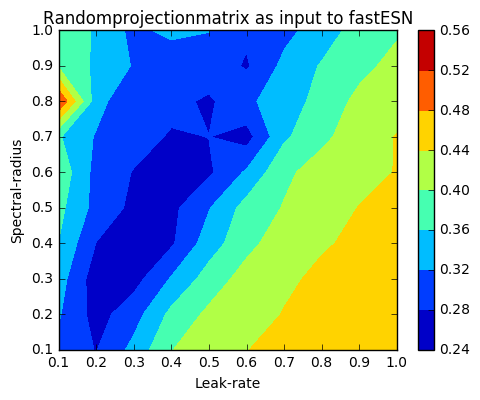

In [20]:
from matplotlib import pyplot
%matplotlib inline
xx, yy = np.meshgrid(l_rate_fast, sp_rad_fast)
pyplot.figure(figsize=(12,14))
pyplot.subplot(3,2,1)
pyplot.contourf(xx,
                yy,fast_errors_averaged_over_trials.reshape(10,10).T)
pyplot.title("Randomprojectionmatrix as input to fastESN")
pyplot.xlabel("Leak-rate")
pyplot.ylabel("Spectral-radius")
pyplot.colorbar()